In [1]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Input, Concatenate, UpSampling2D,BatchNormalization, Add
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import cv2
import nibabel
import random as r
# import pandas as pd
import numpy as np
import random
import glob
from skimage.io import imread,imshow
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from PIL import Image
from keras import backend, optimizers
import skimage.io as io

2024-05-13 19:41:37.557968: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-13 19:41:37.559611: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-13 19:41:37.590948: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-13 19:41:37.591600: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 19:41:38.152727: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
import segmentation_models_3D as sm

Segmentation Models: using `tf.keras` framework.


In [3]:
orig_path = r"./BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
files_flair = glob.glob(orig_path+"**/*flair.nii")
files_t1ce = glob.glob(orig_path+"**/*t1ce.nii")
files_t2 = glob.glob(orig_path+"**/*t2.nii")
files_seg = glob.glob(orig_path+"**/*seg.nii")
r.seed(42)
r.shuffle(files_flair)
r.seed(42)
r.shuffle(files_t1ce)
r.seed(42)
r.shuffle(files_t2)
r.seed(42)
r.shuffle(files_seg)

In [4]:
print(len(files_flair), len(files_t1ce), len(files_t2), len(files_seg))

369 369 369 369


In [5]:
img_num = random.randint(0,len(files_flair)-1)
random_img = io.imread(files_flair[img_num])

print(f"shape: {random_img.shape}")
print(f"dtype: {random_img.dtype}")

shape: (155, 240, 240)
dtype: float32


In [10]:
# def remove_keymap_conflicts(new_keys_set):
#     for prop in plt.rcParams:
#         if prop.startswith('keymap.'):
#             keys = plt.rcParams[prop]
#             remove_list = set(keys) & new_keys_set
#             for key in remove_list:
#                 keys.remove(key)
# def multi_slice_viewer(volume):
#     remove_keymap_conflicts({'j', 'k'})
#     fig, ax = plt.subplots()
#     ax.volume = volume
#     ax.index = volume.shape[0] // 2
#     ax.imshow(volume[ax.index])
#     fig.canvas.mpl_connect('key_press_event', process_key)

# def process_key(event):
#     fig = event.canvas.figure
#     ax = fig.axes[0]
#     if event.key == 'j':
#         previous_slice(ax)
#     elif event.key == 'k':
#         next_slice(ax)
#     fig.canvas.draw()

# def previous_slice(ax):
#     volume = ax.volume
#     ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
#     ax.images[0].set_array(volume[ax.index])

# def next_slice(ax):
#     volume = ax.volume
#     ax.index = (ax.index + 1) % volume.shape[0]
#     ax.images[0].set_array(volume[ax.index])

Image No: 79 slice no: 69


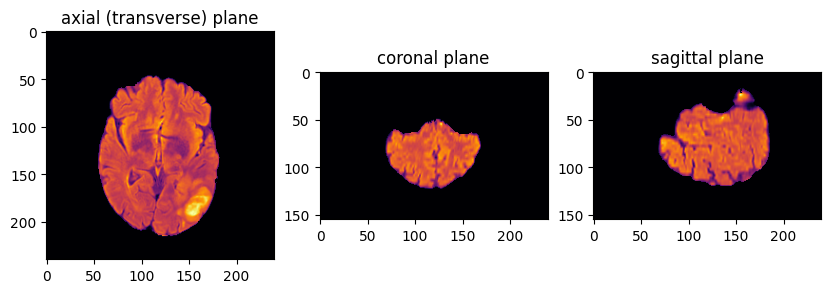

In [9]:
# just showing a random image
img_num = random.randint(0,len(files_flair)-1)
n_slice=random.randint(0, 154)

fig = plt.figure(figsize =(10, 10))

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(random_img[n_slice,:,:], cmap='inferno')
plt.title("axial (transverse) plane")

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(random_img[:,n_slice,:], cmap='inferno')
plt.title("coronal plane")

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(random_img[:,:,n_slice], cmap='inferno')
plt.title("sagittal plane")
print("Image No:", img_num, "slice no:", n_slice)

Text(0.5, 1.0, 'seg')

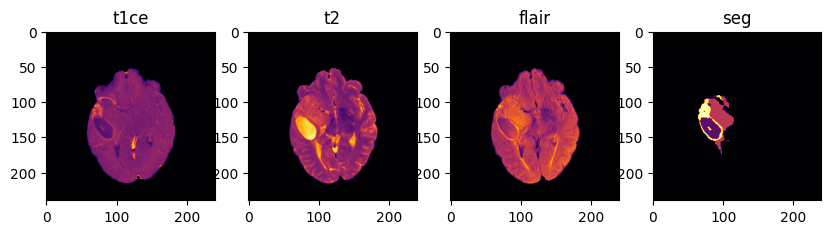

In [11]:
img_num = random.randint(0,len(files_flair)-1)
random_img_t1ce = io.imread(files_t1ce[img_num])
random_img_t2 = io.imread(files_t2[img_num])
random_img_flair = io.imread(files_flair[img_num])
random_img_seg = io.imread(files_seg[img_num])

n_slice=random.randint(0, 154)

fig = plt.figure(figsize =(10, 10))

ax1 = fig.add_subplot(1, 4, 1)
ax1.imshow(random_img_t1ce[n_slice,:,:], cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(1, 4, 2)
ax1.imshow(random_img_t2[n_slice,:,:], cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(1, 4, 3)
ax1.imshow(random_img_flair[n_slice,:,:], cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(1, 4, 4)
ax1.imshow(random_img_seg[n_slice,:,:], cmap='inferno')
plt.title("seg")

In [6]:
# def to_array(path, end):
#     files = glob.glob(path+end, recursive=True)
#     img_list = []
#     r.seed(42)
#     r.shuffle(files)
#     for file in files:
#         img = io.imread(file, plugin="simpleitk")
#         img = (img-img.mean())/img.std()
#         img.astype("float32")
#         for slice in range(60, 70):
#             img_s = img[slice,:,:]
#             img_s = cv2.resize(img_s, (128,128))
#             img_s = np.expand_dims(img_s, axis=2)
#             img_list.append(img_s)
#     return np.array(img_list,np.float32)
def to_array(path):
    t1ce_files = glob.glob(path+"**/*t1ce.nii", recursive=True)
    t2_files = glob.glob(path+"**/*t2.nii", recursive=True)
    flair_files = glob.glob(path+"**/*flair.nii", recursive=True)
    # t1ce_files=sorted(t1ce_files)
    # t2_files=sorted(t2_files)
    # flair_files=sorted(flair_files)

    X = []
    r.seed(42)
    r.shuffle(t1ce_files)
    r.seed(42)
    r.shuffle(t2_files)
    r.seed(42)
    r.shuffle(flair_files)
    for t1ce,t2,flair in zip(t1ce_files, t2_files,flair_files):
        t1ce = io.imread(t1ce, plugin="simpleitk")
        t2 = io.imread(t2, plugin="simpleitk")
        flair = io.imread(flair, plugin="simpleitk")
        t1ce = (t1ce-t1ce.mean())/t1ce.std()
        t2 = (t2-t2.mean())/t2.std()
        flair = (flair-flair.mean())/flair.std()

        t1ce.astype("float32")
        t2.astype("float32")
        flair.astype("float32")

        for slice in range(60, 70):
            img_t1ce = t1ce[slice,:,:]
            img_t2 = t2[slice,:,:]
            img_flair = flair[slice,:,:]

            img_t1ce = cv2.resize(img_t1ce, (128,128))
            img_t2 = cv2.resize(img_t2, (128,128))
            img_flair = cv2.resize(img_flair, (128,128))
            stacked_array = np.dstack((img_t1ce, img_t2, img_flair))

            X.append(stacked_array)
    return np.array(X,np.float32)

In [7]:
def seg_to_array(path, end, p):
    files = glob.glob(path+end, recursive=True)
    # files = sorted(files)
    img_list = []
    r.seed(42)
    r.shuffle(files)
    for file in files:
        img = io.imread(file, plugin="simpleitk")
        if p == 1:#WT 1,2,4 all
            img[img != 0] = 1
        if p == 2:#1
            img[img != 1] = 0
        if p == 3:#CT 1,4 without edema
            img[img == 2] = 0
            img[img != 0] = 1
        if p == 4:#ET 4
            img[img != 4] = 0
            img[img == 4] = 1
        img.astype("float32")
        for slice in range(60, 70):
            img_s = img[slice,:,:]
            img_s = cv2.resize(img_s, (128,128))
            img_s = np.expand_dims(img_s, axis=2)
            img_list.append(img_s)
    return np.array(img_list,np.float32)

In [8]:
# not to be run everytime
#run only if you need to preprocess the data this time

# flair = to_array(path=orig_path, end="**/*flair.nii")
X = to_array(path=orig_path)
# t2 = to_array(path=orig_path, end="**/*t2.nii")
Y = seg_to_array(path=orig_path, end="**/*seg.nii", p=4)

In [23]:
# flair = to_array(path=orig_path, end="**/*flair.nii")
# t2 = to_array(path=orig_path, end="**/*t2.nii")

In [9]:
# seg.shape, t1ce.shape
#t2.shape, flair.shape
X.shape, Y.shape

((3690, 128, 128, 3), (3690, 128, 128, 1))

Text(0.5, 1.0, 'seg 424')

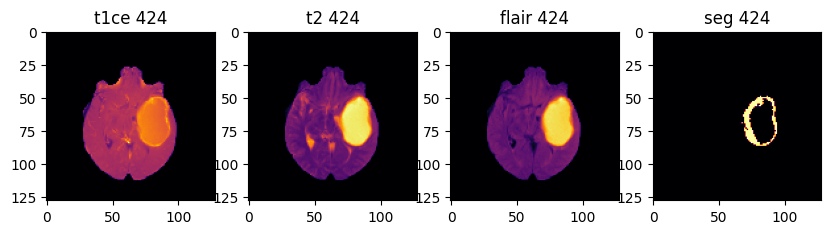

In [11]:
# not to be run everytime
# run only if X and Y has been loaded
img_num = random.randint(0,len(X)-1)
random_img_t1ce = X[img_num,:,:,0]
random_img_t2 = X[img_num,:,:,1]
random_img_flair = X[img_num,:,:,2]
random_img_seg = Y[img_num,:,:,0]

# n_slice=random.randint(0, 154)

fig = plt.figure(figsize =(10, 10))

ax1 = fig.add_subplot(1, 4, 1)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title(f"t1ce {img_num}")

ax1 = fig.add_subplot(1, 4, 2)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title(f"t2 {img_num}")

ax1 = fig.add_subplot(1, 4, 3)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title(f"flair {img_num}")

ax1 = fig.add_subplot(1, 4, 4)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title(f"seg {img_num}")

In [12]:
# not to be run everytime
# run only if X and Y has been loaded

# X_train_t2_flair = np.concatenate((flair, t2))
# X_train_t1ce_t2_flair = np.concatenate((flair, t2, t1ce))

# X_train_t2_flair.shape, X_train_t1ce_t2_flair.shape
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [13]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((2767, 128, 128, 3),
 (923, 128, 128, 3),
 (2767, 128, 128, 1),
 (923, 128, 128, 1))

Text(0.5, 1.0, 'seg')

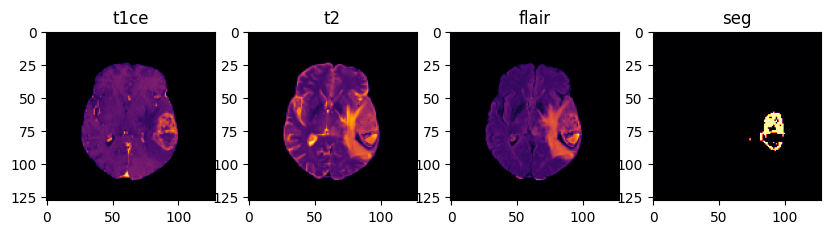

In [14]:
# not to be run everytime
# run only if X_train and Y_train has been loaded

img_num = random.randint(0,len(X_train)-1)
random_img_t1ce = X_train[img_num,:,:,0]
random_img_t2 = X_train[img_num,:,:,1]
random_img_flair = X_train[img_num,:,:,2]
random_img_seg = Y_train[img_num,:,:,0]

# n_slice=random.randint(0, 154)

fig = plt.figure(figsize =(10, 10))

ax1 = fig.add_subplot(1, 4, 1)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(1, 4, 2)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(1, 4, 3)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(1, 4, 4)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title("seg")

Text(0.5, 1.0, 'seg')

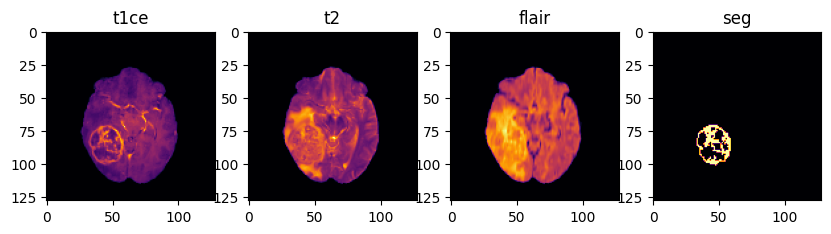

In [16]:
# not to be run everytime
# run only if X_test and Y_test has been loaded

img_num = random.randint(0,len(X_test)-1)
random_img_t1ce = X_test[img_num,:,:,0]
random_img_t2 = X_test[img_num,:,:,1]
random_img_flair = X_test[img_num,:,:,2]
random_img_seg = Y_test[img_num,:,:,0]

# n_slice=random.randint(0, 154)

fig = plt.figure(figsize =(10, 10))

ax1 = fig.add_subplot(1, 4, 1)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(1, 4, 2)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(1, 4, 3)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(1, 4, 4)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title("seg")

In [3]:
import pickle

In [18]:
# not to be run everytime
# run only if you want to save

with open('X_train_ET.pkl', 'wb') as f:
    pickle.dump(X_train, f)

In [19]:
# not to be run everytime
# run only if you want to save

with open('Y_train_ET.pkl', 'wb') as f:
    pickle.dump(Y_train, f)

In [20]:
# not to be run everytime
# run only if you want to save

with open('X_test_ET.pkl', 'wb') as f:
    pickle.dump(X_test, f)

In [21]:
# not to be run everytime
# run only if you want to save

with open('Y_test_ET.pkl', 'wb') as f:
    pickle.dump(Y_test, f)

In [4]:
# loading the saved preprocessed data from local device

with open('X_train_ET.pkl', 'rb') as f:
    X_train_load = pickle.load(f)
with open('Y_train_ET.pkl', 'rb') as f:
    Y_train_load = pickle.load(f)
with open('X_test_ET.pkl', 'rb') as f:
    X_test_load = pickle.load(f)
with open('Y_test_ET.pkl', 'rb') as f:
    Y_test_load = pickle.load(f)

In [23]:
X_train_load.shape, X_test_load.shape, Y_train_load.shape, Y_test_load.shape

((2767, 128, 128, 3),
 (923, 128, 128, 3),
 (2767, 128, 128, 1),
 (923, 128, 128, 1))

Text(0.5, 1.0, 'seg')

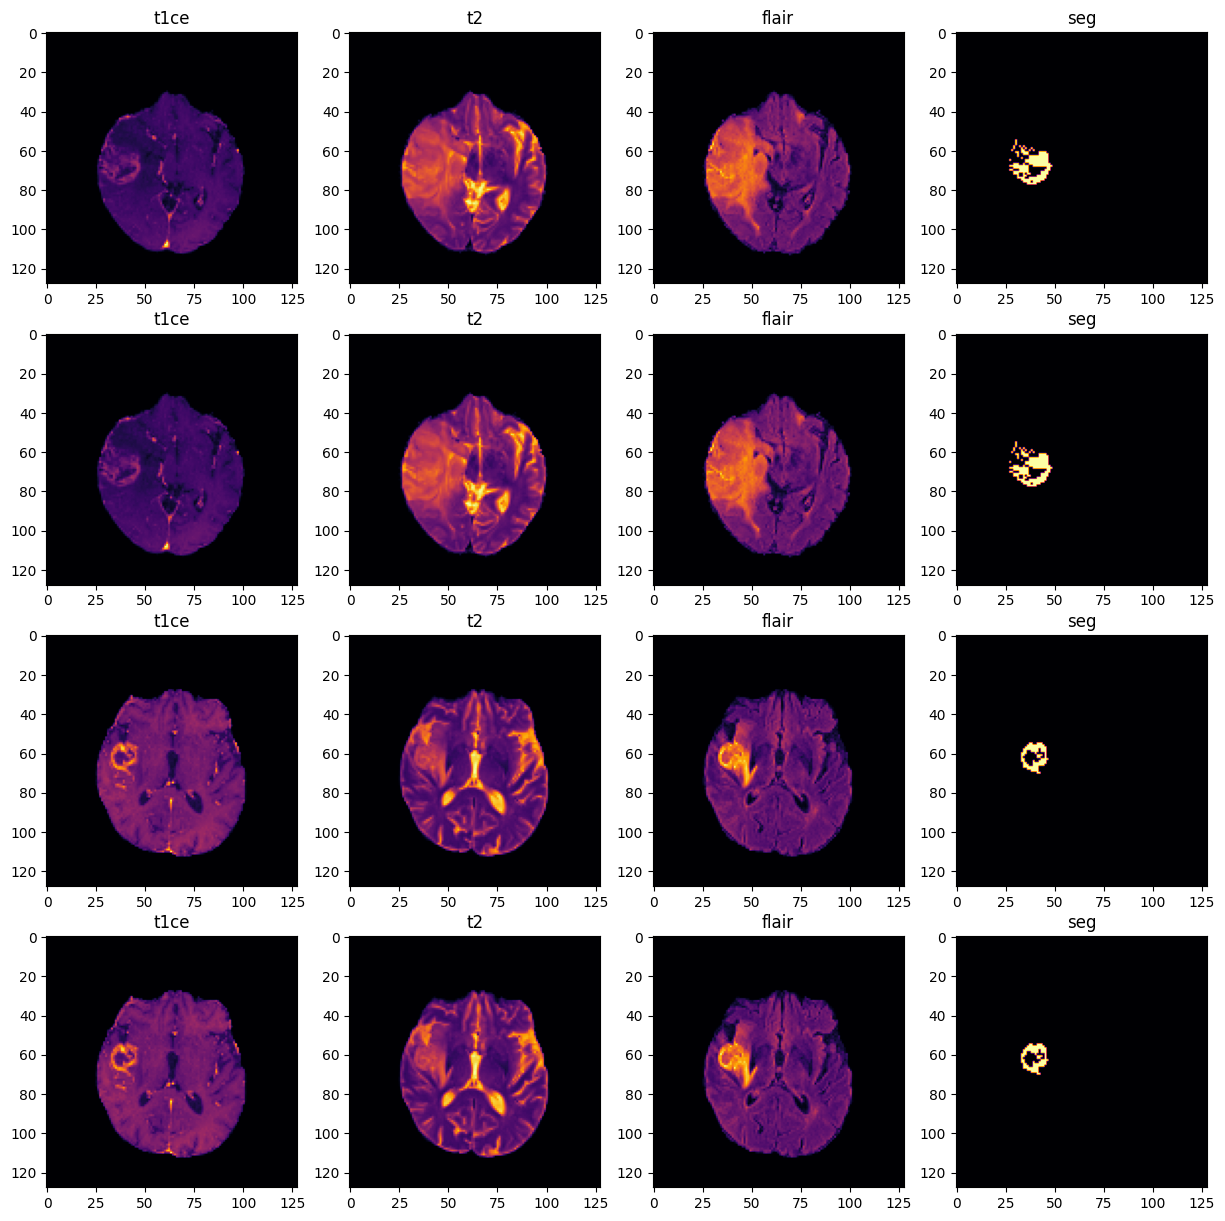

In [27]:
# not to be run everytime
# run only if X_train,X_test,Y_train,Y_test has been loaded

img_num = random.randint(0,len(X_train)-1)

# train
random_img_t1ce = X_train[img_num,:,:,0]
random_img_t2 = X_train[img_num,:,:,1]
random_img_flair = X_train[img_num,:,:,2]
random_img_seg = Y_train[img_num,:,:,0]

# n_slice=random.randint(0, 154)

fig = plt.figure(figsize =(15, 15))

ax1 = fig.add_subplot(4, 4, 1)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(4, 4, 2)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(4, 4, 3)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(4, 4, 4)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title("seg")

# train_load
random_img_t1ce = X_train_load[img_num,:,:,0]
random_img_t2 = X_train_load[img_num,:,:,1]
random_img_flair = X_train_load[img_num,:,:,2]
random_img_seg = Y_train_load[img_num,:,:,0]

# n_slice=random.randint(0, 154)

# fig = plt.figure(figsize =(10, 10))

ax1 = fig.add_subplot(4, 4, 5)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(4, 4, 6)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(4, 4, 7)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(4, 4, 8)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title("seg")

# test

img_num = random.randint(0,len(X_test)-1)

random_img_t1ce = X_test[img_num,:,:,0]
random_img_t2 = X_test[img_num,:,:,1]
random_img_flair = X_test[img_num,:,:,2]
random_img_seg = Y_test[img_num,:,:,0]

# n_slice=random.randint(0, 154)

# fig = plt.figure(figsize =(10, 10))

ax1 = fig.add_subplot(4, 4, 9)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(4, 4, 10)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(4, 4, 11)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(4, 4, 12)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title("seg")

# test_load

# img_num = random.randint(0,len(X_test)-1)

random_img_t1ce = X_test_load[img_num,:,:,0]
random_img_t2 = X_test_load[img_num,:,:,1]
random_img_flair = X_test_load[img_num,:,:,2]
random_img_seg = Y_test_load[img_num,:,:,0]

# n_slice=random.randint(0, 154)

# fig = plt.figure(figsize =(10, 10))

ax1 = fig.add_subplot(4, 4, 13)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(4, 4, 14)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(4, 4, 15)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(4, 4, 16)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title("seg")

In [5]:
X_train = X_train_load
X_test = X_test_load
Y_train = Y_train_load
Y_test = Y_test_load

Text(0.5, 1.0, 'seg')

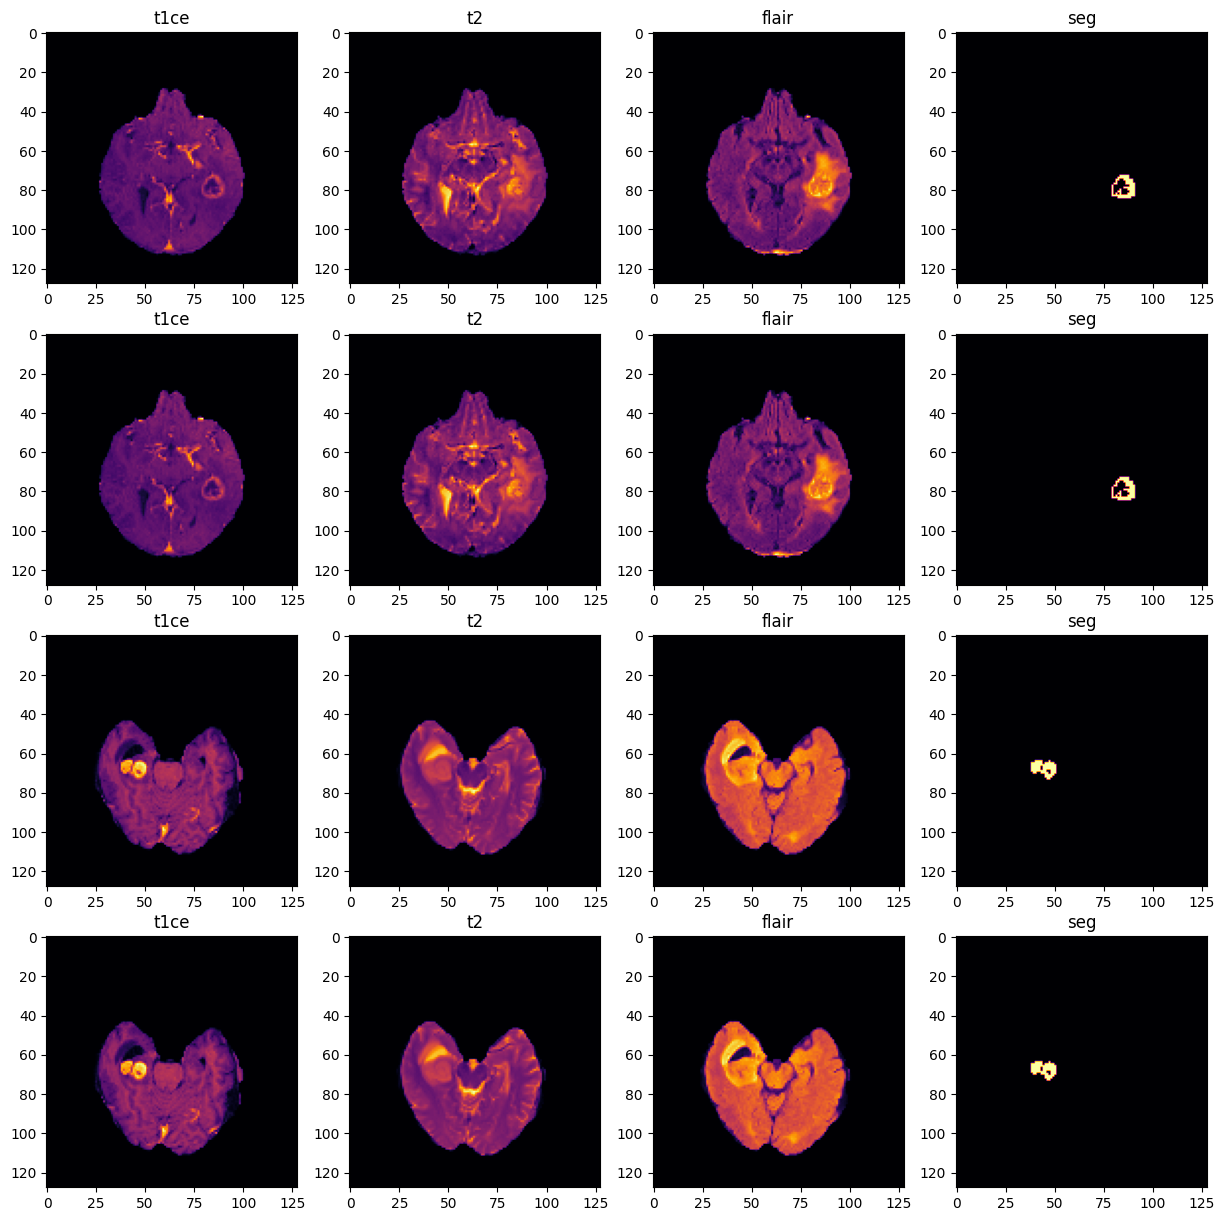

In [32]:


img_num = random.randint(0,len(X_train)-1)

# train
random_img_t1ce = X_train[img_num,:,:,0]
random_img_t2 = X_train[img_num,:,:,1]
random_img_flair = X_train[img_num,:,:,2]
random_img_seg = Y_train[img_num,:,:,0]

# n_slice=random.randint(0, 154)

fig = plt.figure(figsize =(15, 15))

ax1 = fig.add_subplot(4, 4, 1)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(4, 4, 2)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(4, 4, 3)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(4, 4, 4)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title("seg")

# train_load
random_img_t1ce = X_train_load[img_num,:,:,0]
random_img_t2 = X_train_load[img_num,:,:,1]
random_img_flair = X_train_load[img_num,:,:,2]
random_img_seg = Y_train_load[img_num,:,:,0]

# n_slice=random.randint(0, 154)

# fig = plt.figure(figsize =(10, 10))

ax1 = fig.add_subplot(4, 4, 5)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(4, 4, 6)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(4, 4, 7)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(4, 4, 8)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title("seg")

# test

img_num = random.randint(0,len(X_test)-1)

random_img_t1ce = X_test[img_num,:,:,0]
random_img_t2 = X_test[img_num,:,:,1]
random_img_flair = X_test[img_num,:,:,2]
random_img_seg = Y_test[img_num,:,:,0]

# n_slice=random.randint(0, 154)

# fig = plt.figure(figsize =(10, 10))

ax1 = fig.add_subplot(4, 4, 9)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(4, 4, 10)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(4, 4, 11)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(4, 4, 12)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title("seg")

# test_load

# img_num = random.randint(0,len(X_test)-1)

random_img_t1ce = X_test_load[img_num,:,:,0]
random_img_t2 = X_test_load[img_num,:,:,1]
random_img_flair = X_test_load[img_num,:,:,2]
random_img_seg = Y_test_load[img_num,:,:,0]

# n_slice=random.randint(0, 154)

# fig = plt.figure(figsize =(10, 10))

ax1 = fig.add_subplot(4, 4, 13)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(4, 4, 14)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(4, 4, 15)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(4, 4, 16)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title("seg")

In [28]:
# def conv_block(inputs, filters, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal'):
#     conv = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(inputs)
#     conv = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(conv)
#     return conv

# def residual_block(inputs, filters, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal'):
#     res1 = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(inputs)
#     res2 = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(res1)
#     res3 = Conv2D(filters, (1,1), activation=activation, padding=padding, kernel_initializer=kernel_initializer)(res1)
#     res = Add()([res2, res3])
#     return res

# def attention_block(inputs, skip, filters, kernel_size=(1, 1), activation='relu', padding='same', kernel_initializer='he_normal'):
#     g = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(inputs)
#     x = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(skip)
#     x = Add()([g, x])
#     x = Activation('relu')(x)
#     x = Conv2D(1, (1, 1), activation='sigmoid', padding='same', kernel_initializer='he_normal')(x)
#     x = tf.multiply(x, inputs)
#     return x

# def custom_vgg19(input_shape=(256, 256, 1)):
#     inputs = Input(input_shape)
    
#     x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
#     x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#     block_1_out = MaxPooling2D((2, 2), strides=(2, 2))(x)

    
#     x = Conv2D(128, (3, 3), activation='relu', padding='same')(block_1_out)
#     x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#     block_2_out = MaxPooling2D((2, 2), strides=(2, 2))(x)

    
#     x = Conv2D(256, (3, 3), activation='relu', padding='same')(block_2_out)
#     x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
#     block_3_out = MaxPooling2D((2, 2), strides=(2, 2))(x)

    
#     x = Conv2D(512, (3, 3), activation='relu', padding='same')(block_3_out)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#     block_4_out = MaxPooling2D((2, 2), strides=(2, 2))(x)

    
#     x = Conv2D(512, (3, 3), activation='relu', padding='same')(block_4_out)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#     block_5_out = MaxPooling2D((2, 2), strides=(2, 2))(x)

#     return [inputs, block_1_out, block_2_out, block_3_out, block_4_out, block_5_out]

# def vgg19_unet(input_size=(256, 256, 1)):
#     inputs, block_1_out, block_2_out, block_3_out, block_4_out, block_5_out = custom_vgg19(input_shape=input_size)

#     # Build U-Net model
#     conv1 = residual_block(inputs, 64)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
#     conv2 = residual_block(pool1, 128)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
#     conv3 = residual_block(pool2, 256)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
#     conv4 = residual_block(pool3, 512)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

#     conv5 = residual_block(pool4, 1024)
#     batch5 = BatchNormalization()(conv5)

#     up6 = UpSampling2D(size=(2, 2))(batch5)
#     up6 = attention_block(up6, conv4, 512)
#     conv6 = residual_block(up6, 512)
#     batch6 = BatchNormalization()(conv6)

#     up7 = UpSampling2D(size=(2, 2))(batch6)
#     up7 = attention_block(up7, conv3, 256)
#     conv7 = residual_block(up7, 256)
#     batch7 = BatchNormalization()(conv7)

#     up8 = UpSampling2D(size=(2, 2))(batch7)
#     up8 = attention_block(up8, conv2, 128)
#     conv8 = residual_block(up8, 128)
#     batch8 = BatchNormalization()(conv8)

#     up9 = UpSampling2D(size=(2, 2))(batch8)
#     up9 = attention_block(up9, conv1, 64)
#     conv9 = residual_block(up9, 64)
#     batch9 = BatchNormalization()(conv9)

    # conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    # model= Model(inputs=[inputs], outputs=[conv10])
    # return model

In [8]:
# def conv_block(inputs, filters, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal'):
#     conv = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(inputs)
#     conv = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(conv)
#     return conv

# def residual_block(inputs, filters, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal'):
#     res1 = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(inputs)
#     res2 = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(res1)
#     res3 = Conv2D(filters, (1,1), activation=activation, padding=padding, kernel_initializer=kernel_initializer)(res1)
#     res = Add()([res2, res3])
#     return res

# def attention_block(inputs, skip, filters, kernel_size=(1, 1), activation='relu', padding='same', kernel_initializer='he_normal'):
#     g = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(inputs)
#     x = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(skip)
#     x = Add()([g, x])
#     x = Activation('relu')(x)
#     x = Conv2D(1, (1, 1), activation='sigmoid', padding='same', kernel_initializer='he_normal')(x)
#     x = tf.multiply(x, inputs)
#     return x

# def unet_model(input_size=(256, 256, 1)):
#     inputs = Input(input_size)
#     conv1 = residual_block(inputs, 64)
#     batch1 = BatchNormalization()(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(batch1)
#     conv2 = residual_block(pool1, 128)
#     batch2 = BatchNormalization()(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(batch2)
#     conv3 = residual_block(pool2, 256)
#     batch3 = BatchNormalization()(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(batch3)
#     conv4 = residual_block(pool3, 512)
#     batch4 = BatchNormalization()(conv4)
#     drop4 = Dropout(0.5)(batch4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

#     conv5 = residual_block(pool4, 1024)
#     batch5 = BatchNormalization()(conv5)

#     up6 = UpSampling2D(size=(2, 2))(batch5)
#     up6 = attention_block(up6, conv4, 512)

#     conv6 = residual_block(up6, 512)
#     batch6 = BatchNormalization()(conv6)

#     up7 = UpSampling2D(size=(2, 2))(batch6)
#     up7 = attention_block(up7, conv3, 256)

#     conv7 = residual_block(up7, 256)
#     batch7 = BatchNormalization()(conv7)

#     up8 = UpSampling2D(size=(2, 2))(batch7)
    # up8 = attention_block(up8, conv2, 128)
    # conv8 = residual_block(up8, 128)
    # batch8 = BatchNormalization()(conv8)

    # up9 = UpSampling2D(size=(2, 2))(batch8)
    # up9 = attention_block(up9, conv1, 64)
    # conv9 = residual_block(up9, 64)
    # batch9 = BatchNormalization()(conv9)

    # conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)
    # model = Model(inputs=[inputs], outputs=[conv10])

    # return model

In [6]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Multiply

In [12]:
# def squeeze_excite_block(inputs, ratio=8):
#     init = inputs
#     channel_axis = -1
#     filters = init.shape[channel_axis]
#     se_shape = (1, 1, filters)

#     se = GlobalAveragePooling2D()(init)
#     se = Reshape(se_shape)(se)
#     se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
#     se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

#     x = Multiply()([init, se])
#     return x

# def stem_block(x, n_filter, strides):
#     x_init = x

#     ## Conv 1
#     x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)
#     x = Conv2D(n_filter, (3, 3), padding="same")(x)

#     ## Shortcut
#     s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
#     s = BatchNormalization()(s)

#     ## Add
#     x = Add()([x, s])
#     x = squeeze_excite_block(x)
#     return x

# def resnet_block(x, n_filter, strides=1):
#     x_init = x

#     ## Conv 1
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)
#     x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
#     ## Conv 2
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)
#     x = Conv2D(n_filter, (3, 3), padding="same", strides=1)(x)

#     ## Shortcut
#     s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
#     s = BatchNormalization()(s)

#     ## Add
#     x = Add()([x, s])
#     x = squeeze_excite_block(x)
#     return x

# def aspp_block(x, num_filters, rate_scale=1):
#     x1 = Conv2D(num_filters, (3, 3), dilation_rate=(6 * rate_scale, 6 * rate_scale), padding="same")(x)
#     x1 = BatchNormalization()(x1)

#     x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
#     x2 = BatchNormalization()(x2)

#     x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
#     x3 = BatchNormalization()(x3)

#     x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
#     x4 = BatchNormalization()(x4)

#     y = Add()([x1, x2, x3, x4])
#     y = Conv2D(num_filters, (1, 1), padding="same")(y)
#     return y

# def attetion_block(g, x):
#     """
#         g: Output of Parallel Encoder block
#         x: Output of Previous Decoder block
#     """

#     filters = x.shape[-1]

#     g_conv = BatchNormalization()(g)
#     g_conv = Activation("relu")(g_conv)
#     g_conv = Conv2D(filters, (3, 3), padding="same")(g_conv)

#     g_pool = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(g_conv)

#     x_conv = BatchNormalization()(x)
#     x_conv = Activation("relu")(x_conv)
#     x_conv = Conv2D(filters, (3, 3), padding="same")(x_conv)

#     gc_sum = Add()([g_pool, x_conv])

#     gc_conv = BatchNormalization()(gc_sum)
#     gc_conv = Activation("relu")(gc_conv)
#     gc_conv = Conv2D(filters, (3, 3), padding="same")(gc_conv)

#     gc_mul = Multiply()([gc_conv, x])
#     return gc_mul

# def resunetplusplus_model(input_size=(256, 256, 1)):
#     n_filters = [16, 32, 64, 128, 256]
#     inputs = Input(input_size)
    
#     c0 = inputs
#     c1 = stem_block(c0, n_filters[0], strides=1)

#     ## Encoder
#     c2 = resnet_block(c1, n_filters[1], strides=2)
#     c3 = resnet_block(c2, n_filters[2], strides=2)
#     c4 = resnet_block(c3, n_filters[3], strides=2)

#     ## Bridge
#     b1 = aspp_block(c4, n_filters[4])

#     ## Decoder
#     d1 = attetion_block(c3, b1)
#     d1 = UpSampling2D((2, 2))(d1)
#     d1 = Concatenate()([d1, c3])
#     d1 = resnet_block(d1, n_filters[3])

#     d2 = attetion_block(c2, d1)
#     d2 = UpSampling2D((2, 2))(d2)
#     d2 = Concatenate()([d2, c2])
#     d2 = resnet_block(d2, n_filters[2])

#     d3 = attetion_block(c1, d2)
#     d3 = UpSampling2D((2, 2))(d3)
#     d3 = Concatenate()([d3, c1])
#     d3 = resnet_block(d3, n_filters[1])

#     ## output
#     outputs = aspp_block(d3, n_filters[0])
#     outputs = Conv2D(1, (1, 1), padding="same")(outputs)
#     outputs = Activation("sigmoid")(outputs)

#     ## Model
#     model = Model(inputs, outputs)
#     return model

In [13]:
# model = resunetplusplus_model((128,128,3))
# model.summary()

2024-03-27 21:34:51.758435: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-27 21:34:51.832811: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 16)         0         ['batch_normalization[0][0

In [7]:
def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def stem_block(x, n_filter, strides):
    x_init = x

    ## Conv 1
    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same")(x)

    ## Shortcut
    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)

    ## Add
    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x

def resnet_block(x, n_filter, strides=1):
    x_init = x

    ## Conv 1
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
    ## Conv 2
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=1)(x)
    ##  New Conv 3
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=1)(x)
    ## New Conv 4
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=1)(x)

    ## Shortcut
    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)

    ## Add
    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x

def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(6 * rate_scale, 6 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x2, x3, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(y)
    return y

def attetion_block(g, x):
    """
        g: Output of Parallel Encoder block
        x: Output of Previous Decoder block
    """

    filters = x.shape[-1]

    g_conv = BatchNormalization()(g)
    g_conv = Activation("relu")(g_conv)
    g_conv = Conv2D(filters, (3, 3), padding="same")(g_conv)

    g_pool = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(g_conv)

    x_conv = BatchNormalization()(x)
    x_conv = Activation("relu")(x_conv)
    x_conv = Conv2D(filters, (3, 3), padding="same")(x_conv)

    gc_sum = Add()([g_pool, x_conv])

    gc_conv = BatchNormalization()(gc_sum)
    gc_conv = Activation("relu")(gc_conv)
    gc_conv = Conv2D(filters, (3, 3), padding="same")(gc_conv)

    gc_mul = Multiply()([gc_conv, x])
    return gc_mul

def custom_unet(input_size=(256, 256, 1)):
    n_filters = [16, 32, 64, 128, 256]
    inputs = Input(input_size)
    
    c0 = inputs
    c1 = stem_block(c0, n_filters[0], strides=1)

    ## Encoder
    c2 = resnet_block(c1, n_filters[1], strides=2)
    c3 = resnet_block(c2, n_filters[2], strides=2)
    c4 = resnet_block(c3, n_filters[3], strides=2)

    ## Bridge
    b1 = aspp_block(c4, n_filters[4])

    ## Decoder
    d1 = attetion_block(c3, b1)
    d1 = UpSampling2D((2, 2))(d1)
    d1 = Concatenate()([d1, c3])
    d1 = resnet_block(d1, n_filters[3])

    d2 = attetion_block(c2, d1)
    d2 = UpSampling2D((2, 2))(d2)
    d2 = Concatenate()([d2, c2])
    d2 = resnet_block(d2, n_filters[2])

    d3 = attetion_block(c1, d2)
    d3 = UpSampling2D((2, 2))(d3)
    d3 = Concatenate()([d3, c1])
    d3 = resnet_block(d3, n_filters[1])

    ## output
    outputs = aspp_block(d3, n_filters[0])
    outputs = Conv2D(1, (1, 1), padding="same")(outputs)
    outputs = Activation("sigmoid")(outputs)

    ## Model
    model = Model(inputs, outputs)
    return model

In [8]:
#custom_unet
new_model = custom_unet((128,128,3))
new_model.summary()

2024-05-13 19:43:15.617863: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-13 19:43:15.627658: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 16)         0         ['batch_normalization[0][0

In [38]:
%pip install pydot graphviz

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [9]:
# import tensorflow as tf
import pydot
import graphviz
from tensorflow.keras.utils import plot_model
# from tensorflow.keras.utils import pydot
# from keras.utils.vis_utils import pydot
# from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

# Assuming 'new_model' is your Keras model
# plot_model(new_model, to_file='m_resunetplusplus_model.png', show_shapes=True, show_layer_names=True)
# tf.keras.utils.plot_model(new_model, to_file='m_resunetplusplus_model.png', show_shapes=True, show_layer_names=True)
# Display the model visualization directly
# plt.show()

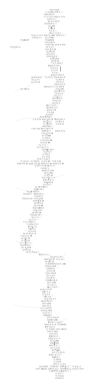

In [10]:
tf.keras.utils.plot_model(new_model, to_file='m_resunetplusplus_model.png', show_shapes=True, show_layer_names=True)
img = plt.imread('m_resunetplusplus_model.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [10]:
import keras

In [11]:
#from tensorflow.keras.callbacks import EarlyStopping

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [12]:
# from tensorflow.keras.losses import BinaryCrossentropy
# from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.metrics import Precision, Recall, MeanIoU


In [13]:
smooth = 1.
def dice_score(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
def dice_loss(y_true, y_pred):
    return 1.0 - dice_score(y_true, y_pred)

In [14]:
def sensitivity(y_true, y_pred):
    # Convert predicted probabilities to binary values (0 or 1)
    y_pred_binary = tf.cast(y_pred > 0.5, dtype=tf.float32)
    # Calculate true positives (TP) and actual positives (AP)
    TP = tf.reduce_sum(y_true * y_pred_binary)
    AP = tf.reduce_sum(y_true)
    # Calculate sensitivity (recall) as TP / AP
    sensitivity = TP / (AP + tf.keras.backend.epsilon())  # Add epsilon to avoid division by zero
    return sensitivity
def specificity(y_true, y_pred):
    # Convert predicted probabilities to binary values (0 or 1)
    y_pred_binary = tf.cast(y_pred > 0.5, dtype=tf.float32)
    
    # Calculate true negatives (TN)
    TN = tf.reduce_sum((1 - y_true) * (1 - y_pred_binary))
    
    # Calculate false positives (FP)
    FP = tf.reduce_sum((1 - y_true) * y_pred_binary)
    
    # Calculate specificity as TN / (TN + FP)
    spec = TN / (TN + FP + tf.keras.backend.epsilon())  # Add epsilon to avoid division by zero
    
    return spec

In [15]:
#n_classes = 4
#activation = 'softmax'
#LR = 0.0001
#optim = keras.optimizers.Adam(LR)
loss=dice_loss
#loss='binary_crossentropy'
#loss = sm.losses.DiceLoss(class_weights=np.array())
#dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25]))
# focal_loss = sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)

metrics = [dice_score,MeanIoU(num_classes=2),sm.metrics.IOUScore(threshold=0.5),sm.metrics.FScore(threshold=0.5),Recall(),Precision(),sensitivity,specificity]
#metrics = [dice_score,MeanIoU(num_classes=2),sm.metrics.IOUScore(threshold=0.5),sm.metrics.FScore(threshold=0.5)]
#metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [16]:
from tensorflow.keras.optimizers import Nadam
lr=1e-4
optim=Nadam(lr)

In [17]:
#early_stopping = EarlyStopping(monitor='loss', patience=2)

In [17]:
new_model.compile(optim, loss, metrics=metrics)

In [44]:
# training for 15 epoch
new_model.fit(X_train, Y_train, batch_size=16, epochs=15, shuffle=False)

new_model.save('./Brats2020_2DSegmentation_nadam_customUnet_copy6_15.hdf5')

Epoch 1/15
173/173 [==============================] - 437s 2s/step - loss: 0.8974 - dice_score: 0.1027 - mean_io_u: 0.5345 - iou_score: 0.0725 - f1-score: 0.1315 - recall: 0.9365 - precision: 0.0478 - sensitivity: 0.9377 - specificity: 0.9025
Epoch 2/15
173/173 [==============================] - 360s 2s/step - loss: 0.6837 - dice_score: 0.3164 - mean_io_u: 0.6154 - iou_score: 0.2499 - f1-score: 0.3901 - recall: 0.9221 - precision: 0.2362 - sensitivity: 0.9256 - specificity: 0.9844
Epoch 3/15
173/173 [==============================] - 365s 2s/step - loss: 0.4556 - dice_score: 0.5444 - mean_io_u: 0.7245 - iou_score: 0.4495 - f1-score: 0.6123 - recall: 0.8699 - precision: 0.4823 - sensitivity: 0.8774 - specificity: 0.9951
Epoch 4/15
173/173 [==============================] - 364s 2s/step - loss: 0.3230 - dice_score: 0.6770 - mean_io_u: 0.7796 - iou_score: 0.5622 - f1-score: 0.7141 - recall: 0.8416 - precision: 0.6368 - sensitivity: 0.8496 - specificity: 0.9975
Epoch 5/15
173/173 [========

/home/arka/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
# for loading 15 epoch trained model
from keras.models import load_model

new_model = load_model(r'./Brats2020_2DSegmentation_nadam_customUnet_copy6_15.hdf5', compile=False)

new_model.compile(optim, loss, metrics=metrics)

In [46]:
#evaluting for 15 epochs
res = new_model.evaluate(X_test,Y_test,batch_size=16)

58/58 [==============================] - 107s 633ms/step - loss: 0.3123 - dice_score: 0.6886 - mean_io_u: 0.8092 - iou_score: 0.5478 - f1-score: 0.6891 - recall: 0.8315 - precision: 0.7388 - sensitivity: 0.7504 - specificity: 0.9963


In [19]:
# training for epoch 16 to 35
new_model.fit(X_train, Y_train, batch_size=16, epochs=20, shuffle=False)

new_model.save('./Brats2020_2DSegmentation_nadam_customUnet_copy6_35.hdf5')

Epoch 1/20
173/173 [==============================] - 425s 2s/step - loss: 0.1502 - dice_score: 0.8498 - mean_io_u: 0.8625 - iou_score: 0.7418 - f1-score: 0.8506 - recall: 0.8638 - precision: 0.8476 - sensitivity: 0.8658 - specificity: 0.9992
Epoch 2/20
173/173 [==============================] - 378s 2s/step - loss: 0.1553 - dice_score: 0.8447 - mean_io_u: 0.8586 - iou_score: 0.7336 - f1-score: 0.8451 - recall: 0.8609 - precision: 0.8393 - sensitivity: 0.8642 - specificity: 0.9991
Epoch 3/20
173/173 [==============================] - 379s 2s/step - loss: 0.1561 - dice_score: 0.8440 - mean_io_u: 0.8587 - iou_score: 0.7324 - f1-score: 0.8442 - recall: 0.8569 - precision: 0.8432 - sensitivity: 0.8591 - specificity: 0.9992
Epoch 4/20
173/173 [==============================] - 378s 2s/step - loss: 0.1421 - dice_score: 0.8579 - mean_io_u: 0.8695 - iou_score: 0.7532 - f1-score: 0.8581 - recall: 0.8723 - precision: 0.8534 - sensitivity: 0.8740 - specificity: 0.9992
Epoch 5/20
173/173 [========

/home/arka/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
# for loading 35 epoch trained model
from keras.models import load_model

new_model = load_model(r'./Brats2020_2DSegmentation_nadam_customUnet_copy6_35.hdf5', compile=False)

new_model.compile(optim, loss, metrics=metrics)

In [21]:
#evaluting for 35 epochs
res = new_model.evaluate(X_test,Y_test,batch_size=16)

58/58 [==============================] - 94s 597ms/step - loss: 0.1435 - dice_score: 0.8565 - mean_io_u: 0.8880 - iou_score: 0.7524 - f1-score: 0.8566 - recall: 0.8810 - precision: 0.8758 - sensitivity: 0.8704 - specificity: 0.9991


In [19]:
# Define model checkpointing
checkpoint_path = "./Brats2020_2DSegmentation_nadam_customUnet_copy6_best(36,50).hdf5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='loss', verbose=1, save_best_only=True, mode='min')

In [20]:
# Train the model for 36 to 50
history_from_35 = new_model.fit(X_train, Y_train, epochs=15, batch_size=16, callbacks=[checkpoint])

Epoch 1/15
173/173 [==============================] - ETA: 0s - loss: 0.1288 - dice_score: 0.8712 - mean_io_u: 0.8861 - iou_score: 0.7740 - f1-score: 0.8714 - recall: 0.8751 - precision: 0.8807 - sensitivity: 0.8752 - specificity: 0.9994
Epoch 1: loss improved from inf to 0.12880, saving model to ./Brats2020_2DSegmentation_nadam_customUnet_copy6_best(36,50).hdf5


/home/arka/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


173/173 [==============================] - 414s 2s/step - loss: 0.1288 - dice_score: 0.8712 - mean_io_u: 0.8861 - iou_score: 0.7740 - f1-score: 0.8714 - recall: 0.8751 - precision: 0.8807 - sensitivity: 0.8752 - specificity: 0.9994
Epoch 2/15
173/173 [==============================] - ETA: 0s - loss: 0.1257 - dice_score: 0.8743 - mean_io_u: 0.8882 - iou_score: 0.7787 - f1-score: 0.8744 - recall: 0.8805 - precision: 0.8789 - sensitivity: 0.8824 - specificity: 0.9994
Epoch 2: loss improved from 0.12880 to 0.12569, saving model to ./Brats2020_2DSegmentation_nadam_customUnet_copy6_best(36,50).hdf5
173/173 [==============================] - 381s 2s/step - loss: 0.1257 - dice_score: 0.8743 - mean_io_u: 0.8882 - iou_score: 0.7787 - f1-score: 0.8744 - recall: 0.8805 - precision: 0.8789 - sensitivity: 0.8824 - specificity: 0.9994
Epoch 3/15
173/173 [==============================] - ETA: 0s - loss: 0.1227 - dice_score: 0.8773 - mean_io_u: 0.8903 - iou_score: 0.7835 - f1-score: 0.8774 - recall: 

In [18]:
# for loading 50 epoch trained model
from keras.models import load_model

new_model = load_model(r'./Brats2020_2DSegmentation_nadam_customUnet_copy6_best(36,50).hdf5', compile=False)

new_model.compile(optim, loss, metrics=metrics)

In [22]:
#evaluting for 50 epochs
res = new_model.evaluate(X_test,Y_test,batch_size=16)

58/58 [==============================] - 52s 599ms/step - loss: 0.1395 - dice_score: 0.8606 - mean_io_u: 0.8954 - iou_score: 0.7573 - f1-score: 0.8605 - recall: 0.8802 - precision: 0.8992 - sensitivity: 0.8280 - specificity: 0.9995


In [19]:
# Define model checkpointing
checkpoint_path = "./Brats2020_2DSegmentation_nadam_customUnet_copy6_best(51,60).hdf5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='loss', verbose=1, save_best_only=True, mode='min')

In [20]:
# Train the model for 51 to 60
history_from_50 = new_model.fit(X_train, Y_train, epochs=10, batch_size=16, callbacks=[checkpoint])

Epoch 1/10
173/173 [==============================] - ETA: 0s - loss: 0.1077 - dice_score: 0.8923 - mean_io_u: 0.9032 - iou_score: 0.8069 - f1-score: 0.8923 - recall: 0.8961 - precision: 0.8984 - sensitivity: 0.8922 - specificity: 0.9995
Epoch 1: loss improved from inf to 0.10771, saving model to ./Brats2020_2DSegmentation_nadam_customUnet_copy6_best(51,60).hdf5


/home/arka/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


173/173 [==============================] - 421s 2s/step - loss: 0.1077 - dice_score: 0.8923 - mean_io_u: 0.9032 - iou_score: 0.8069 - f1-score: 0.8923 - recall: 0.8961 - precision: 0.8984 - sensitivity: 0.8922 - specificity: 0.9995
Epoch 2/10
173/173 [==============================] - ETA: 0s - loss: 0.1083 - dice_score: 0.8917 - mean_io_u: 0.9029 - iou_score: 0.8059 - f1-score: 0.8919 - recall: 0.8985 - precision: 0.8941 - sensitivity: 0.8971 - specificity: 0.9994
Epoch 2: loss did not improve from 0.10771
173/173 [==============================] - 380s 2s/step - loss: 0.1083 - dice_score: 0.8917 - mean_io_u: 0.9029 - iou_score: 0.8059 - f1-score: 0.8919 - recall: 0.8985 - precision: 0.8941 - sensitivity: 0.8971 - specificity: 0.9994
Epoch 3/10
173/173 [==============================] - ETA: 0s - loss: 0.1060 - dice_score: 0.8940 - mean_io_u: 0.9037 - iou_score: 0.8093 - f1-score: 0.8940 - recall: 0.9008 - precision: 0.8955 - sensitivity: 0.8993 - specificity: 0.9994
Epoch 3: loss imp

In [18]:
# for loading 57 epoch trained model
from keras.models import load_model

new_model = load_model(r'./Brats2020_2DSegmentation_nadam_customUnet_copy6_best(51,60).hdf5', compile=False)

new_model.compile(optim, loss, metrics=metrics)

In [22]:
#evaluting for 57 epochs
res = new_model.evaluate(X_test,Y_test,batch_size=16)

58/58 [==============================] - 54s 597ms/step - loss: 0.1270 - dice_score: 0.8730 - mean_io_u: 0.9013 - iou_score: 0.7761 - f1-score: 0.8731 - recall: 0.8931 - precision: 0.8981 - sensitivity: 0.8554 - specificity: 0.9994


In [19]:
# Define model checkpointing
checkpoint_path = "./Brats2020_2DSegmentation_nadam_customUnet_copy6_best(58,70).hdf5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='loss', verbose=1, save_best_only=True, mode='min')

In [20]:
# Train the model for 58 to 70
history_from_57 = new_model.fit(X_train, Y_train, epochs=13, batch_size=16, callbacks=[checkpoint])

Epoch 1/13
173/173 [==============================] - ETA: 0s - loss: 0.1009 - dice_score: 0.8991 - mean_io_u: 0.9070 - iou_score: 0.8177 - f1-score: 0.8992 - recall: 0.9024 - precision: 0.9010 - sensitivity: 0.9022 - specificity: 0.9995
Epoch 1: loss improved from inf to 0.10088, saving model to ./Brats2020_2DSegmentation_nadam_customUnet_copy6_best(58,70).hdf5


/home/arka/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


173/173 [==============================] - 436s 2s/step - loss: 0.1009 - dice_score: 0.8991 - mean_io_u: 0.9070 - iou_score: 0.8177 - f1-score: 0.8992 - recall: 0.9024 - precision: 0.9010 - sensitivity: 0.9022 - specificity: 0.9995
Epoch 2/13
173/173 [==============================] - ETA: 0s - loss: 0.1036 - dice_score: 0.8964 - mean_io_u: 0.9068 - iou_score: 0.8136 - f1-score: 0.8964 - recall: 0.9013 - precision: 0.9027 - sensitivity: 0.8981 - specificity: 0.9995
Epoch 2: loss did not improve from 0.10088
173/173 [==============================] - 381s 2s/step - loss: 0.1036 - dice_score: 0.8964 - mean_io_u: 0.9068 - iou_score: 0.8136 - f1-score: 0.8964 - recall: 0.9013 - precision: 0.9027 - sensitivity: 0.8981 - specificity: 0.9995
Epoch 3/13
173/173 [==============================] - ETA: 0s - loss: 0.0983 - dice_score: 0.9017 - mean_io_u: 0.9085 - iou_score: 0.8217 - f1-score: 0.9017 - recall: 0.9069 - precision: 0.9014 - sensitivity: 0.9060 - specificity: 0.9995
Epoch 3: loss imp

In [23]:
# for loading 69 epoch trained model
from keras.models import load_model

new_model = load_model(r'./Brats2020_2DSegmentation_nadam_customUnet_copy6_best(58,70).hdf5', compile=False)

new_model.compile(optim, loss, metrics=metrics)

In [22]:
#evaluting for 69 epochs
res = new_model.evaluate(X_test,Y_test,batch_size=16)

58/58 [==============================] - 61s 600ms/step - loss: 0.1105 - dice_score: 0.8895 - mean_io_u: 0.9076 - iou_score: 0.8018 - f1-score: 0.8894 - recall: 0.8993 - precision: 0.9077 - sensitivity: 0.8697 - specificity: 0.9995


In [19]:
keras.backend.clear_session()

In [ ]:
# training for EPOCH 52-54

#history_from_51 = new_model.fit(X_train, Y_train, batch_size=16, epochs=3, shuffle=False)

#new_model.save('./Brats2020_2D_Segmentation_08_03_24_54_EPOCH.hdf5')

In [13]:
# for loading 54 epoch trained model
#from keras.models import load_model

#new_model = load_model(r"./Brats2020_2D_Segmentation_08_03_24_54_EPOCH.hdf5", compile=False)

#new_model.compile(optim, dice_loss, metrics=metrics)

In [34]:
# n_classes = 4 # -->class0, c1, c2, c3;
# activation = 'softmax'
# LR = 0.0001
# optim = keras.optimizers.Adam(LR)

# dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25]))
# focal_loss = sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss) # # actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses; total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss

# metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [35]:
# for loading partially trained model
# from keras.models import load_model

# new_model = load_model(r"./brats_2020_2D_segmentation_t1ce.hdf5", compile=False)

# new_model.compile(optim, total_loss, metrics=metrics)


In [ ]:
# preds_val = new_model.predict(final, verbose=1)
# preds_val = (preds_val > 0.5)

In [39]:
# for loading partially trained model
# from keras.models import load_model

# new_model = load_model(r"./brats_2020_2D_segmentation_t1ce_10_+_50_epochs.hdf5", compile=False)

# new_model.compile(optim, total_loss, metrics=metrics)


In [ ]:
# loss = history_from_10.history['loss']
# val_loss = history_from_10.history['val_loss']
# epochs = range(1, len(loss) + 1)
# plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# iou = history_from_10.history['iou_score']
# val_iou = history_from_10.history['val_iou_score']

# plt.plot(epochs, iou, 'y', label='Training accuracy')
# plt.plot(epochs, val_iou, 'r', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# f1_score = history_from_10.history['f1-score']
# val_f1_score = history_from_10.history['val_f1-score']

# plt.plot(epochs, f1_score, 'y', label='Training accuracy')
# plt.plot(epochs, val_f1_score, 'r', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [41]:
#val_t1ce = to_array("BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/",end="**/*t1ce.nii")

In [ ]:
# img_num = random.randint(0,len(files)-1)
# plt.imshow(seg[img_num])
# print("Mask of", img_num, "th t1ce : " )

1/1 [==============================] - 0s 53ms/step


Text(0.5, 1.0, 'prediction 178')

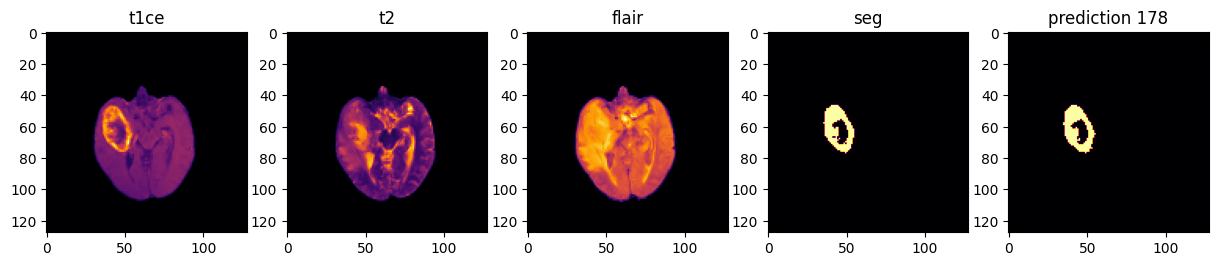

In [20]:
# PREDICTING FOR 57 EPOCH
img_num = random.randint(0,len(X_test)-1)
random_img_t1ce = X_test[img_num,:,:,0]
random_img_t2 = X_test[img_num,:,:,1]
random_img_flair = X_test[img_num,:,:,2]
random_img_seg = Y_test[img_num,:,:,0]

img=np.expand_dims(X_test[img_num], axis=0)
preds_val = new_model.predict(img, verbose=1)


preds_val=preds_val[0]
preds_val = (preds_val > 0.5)
fig = plt.figure(figsize =(15, 15))

ax1 = fig.add_subplot(1, 5, 1)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(1, 5, 2)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(1, 5, 3)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(1, 5, 4)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title("seg")

ax1 = fig.add_subplot(1, 5, 5)
ax1.imshow(preds_val, cmap='inferno')
plt.title(f"prediction {img_num}")

In [ ]:
#178

1/1 [==============================] - 0s 49ms/step


Text(0.5, 1.0, 'prediction 3')

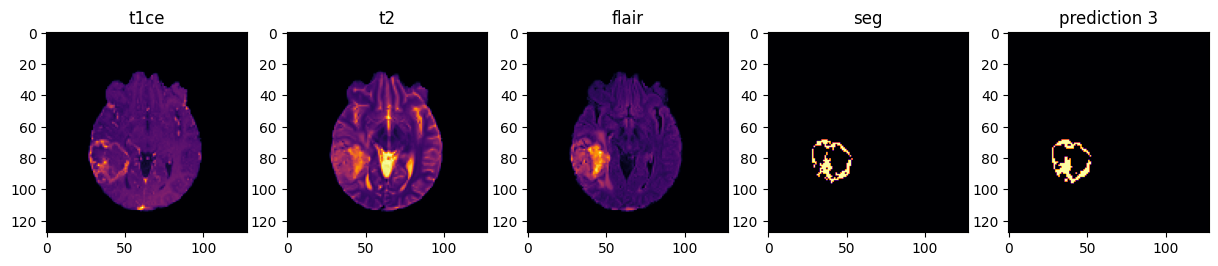

In [31]:
# PREDICTING FOR 57 EPOCH
img_num = random.randint(0,len(X_test)-1)
random_img_t1ce = X_test[img_num,:,:,0]
random_img_t2 = X_test[img_num,:,:,1]
random_img_flair = X_test[img_num,:,:,2]
random_img_seg = Y_test[img_num,:,:,0]

img=np.expand_dims(X_test[img_num], axis=0)
preds_val = new_model.predict(img, verbose=1)


preds_val=preds_val[0]
preds_val = (preds_val > 0.5)
fig = plt.figure(figsize =(15, 15))

ax1 = fig.add_subplot(1, 5, 1)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(1, 5, 2)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(1, 5, 3)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(1, 5, 4)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title("seg")

ax1 = fig.add_subplot(1, 5, 5)
ax1.imshow(preds_val, cmap='inferno')
plt.title(f"prediction {img_num}")

In [ ]:
#3

1/1 [==============================] - 0s 45ms/step


Text(0.5, 1.0, 'prediction 34')

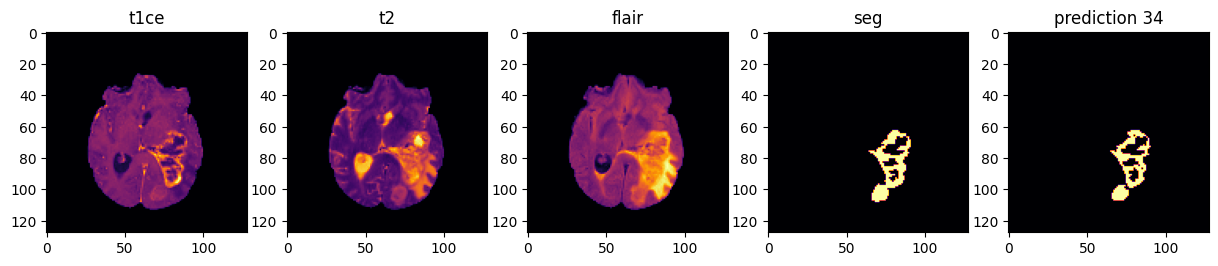

In [26]:
# PREDICTING FOR 69 EPOCH
img_num = random.randint(0,len(X_test)-1)
random_img_t1ce = X_test[img_num,:,:,0]
random_img_t2 = X_test[img_num,:,:,1]
random_img_flair = X_test[img_num,:,:,2]
random_img_seg = Y_test[img_num,:,:,0]

img=np.expand_dims(X_test[img_num], axis=0)
preds_val = new_model.predict(img, verbose=1)


preds_val=preds_val[0]
preds_val = (preds_val > 0.5)
fig = plt.figure(figsize =(15, 15))

ax1 = fig.add_subplot(1, 5, 1)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(1, 5, 2)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(1, 5, 3)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(1, 5, 4)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title("seg")

ax1 = fig.add_subplot(1, 5, 5)
ax1.imshow(preds_val, cmap='inferno')
plt.title(f"prediction {img_num}")

In [ ]:
#34

1/1 [==============================] - 0s 50ms/step


Text(0.5, 1.0, 'prediction 401')

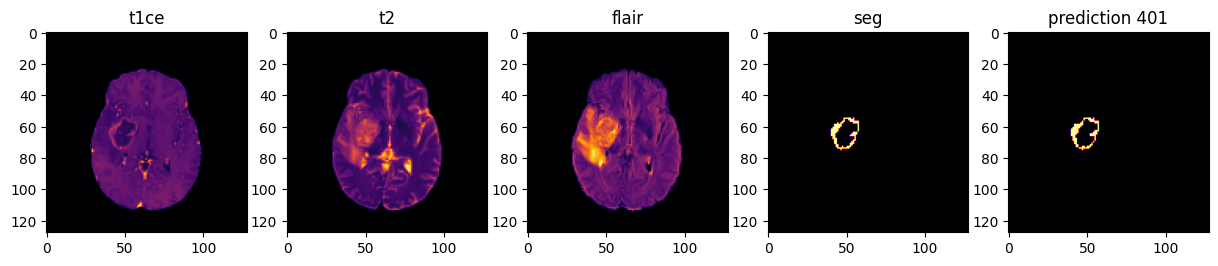

In [27]:
# PREDICTING FOR 69 EPOCH
img_num = random.randint(0,len(X_test)-1)
random_img_t1ce = X_test[img_num,:,:,0]
random_img_t2 = X_test[img_num,:,:,1]
random_img_flair = X_test[img_num,:,:,2]
random_img_seg = Y_test[img_num,:,:,0]

img=np.expand_dims(X_test[img_num], axis=0)
preds_val = new_model.predict(img, verbose=1)


preds_val=preds_val[0]
preds_val = (preds_val > 0.5)
fig = plt.figure(figsize =(15, 15))

ax1 = fig.add_subplot(1, 5, 1)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(1, 5, 2)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(1, 5, 3)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(1, 5, 4)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title("seg")

ax1 = fig.add_subplot(1, 5, 5)
ax1.imshow(preds_val, cmap='inferno')
plt.title(f"prediction {img_num}")

In [ ]:
#401

In [ ]:
# x = random.randint(0,len(files)-1)

# sample = np.expand_dims(t1ce[x], axis=0)
# pred = new_model.predict(sample)

# fig = plt.figure(figsize=(10, 10))

# plt.subplot(1,4,1)
# plt.title("Input: Flair + t2 + t1ce")
# plt.imshow(X_train_t1ce_t2_flair[x], cmap="inferno")

# plt.subplot(1,4,2)
# plt.title("Segmentation")
# plt.imshow(seg[x], cmap="inferno")

# predicted_image = (preds_val_t[x] * 255).astype(np.uint8)
# plt.subplot(1,4,3)
# plt.title("Prediction")
# plt.imshow(predicted_image, cmap="inferno");

In [46]:
# img_list=[]
# img = io.imread(files_t1ce[365], plugin="simpleitk")

# # standardization
# img = (img-img.mean())/img.std()
# img.astype("float32")

# for slice in range(1, 154):
#     img_s = img[slice,:,:]

#     img_s = cv2.resize(img_s, (128,128))

#     img_s = np.expand_dims(img_s, axis=2)
#     img_list.append(img_s)
# final =  np.array(img_list,np.float32)

In [63]:
# img_list=[]
# img = io.imread(files_seg[365], plugin="simpleitk")

# # standardization
# img = (img-img.mean())/img.std()
# #img[img != 0] = 1
# img.astype("float32")

# for slice in range(1, 154):
#     img_s = img[slice,:,:]

#     img_s = cv2.resize(img_s, (128,128))

#     img_s = np.expand_dims(img_s, axis=2)
#     img_list.append(img_s)
# final_seg =  np.array(img_list,np.float32)

In [64]:
# final_seg.shape

(153, 128, 128, 1)

In [ ]:
# for i in range(72,80):

#     fig = plt.figure(figsize=(10,10))
#     plt.subplot(1,4,1)
#     plt.title(f"Input: 365_t1ce, {i}th slice", fontsize = 7)
#     plt.imshow(final[i], cmap="inferno")

#     plt.subplot(1,4,2)
#     plt.title(f"Segmentation, {i}th slice", fontsize = 7)
#     plt.imshow(final_seg[i], cmap="inferno")

#     plt.subplot(1,4,3)
#     plt.title(f"Prediction, {i}th slice", fontsize = 7)
#     plt.imshow(preds_val[i], cmap="inferno");